In [30]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pygsp import graphs, filters
import sys

In [31]:
np.set_printoptions(threshold=sys.maxsize)

<p>
This rapresent a little demonstration of graph fourier transform applied to the denising of a graph. <br>
In order to give this example i've used the famous swiss roll dataset. I've first plotted the normal swiss roll, then the noised version, in which i've corrupted the original signal with a naive noise (add or subtract 0.01 from the original noise).
</p>

In [3]:
from sklearn import datasets

data=sklearn.datasets.make_swiss_roll(n_samples=2094)

In [16]:
data_1_scaled=(data[1]-np.mean(data[1]))/(np.std(data[1]))**2

In [63]:
new_data_1=np.copy(data_1_scaled)
index=np.random.random_integers(0,2094,50)
a=[-1,1]
for i in index:
    new_data_1[i]=a[np.random.binomial(1,0.5)]+0.01

/tmp/ipykernel_52049/2516806051.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 2094 + 1) instead
  index=np.random.random_integers(0,2094,50)


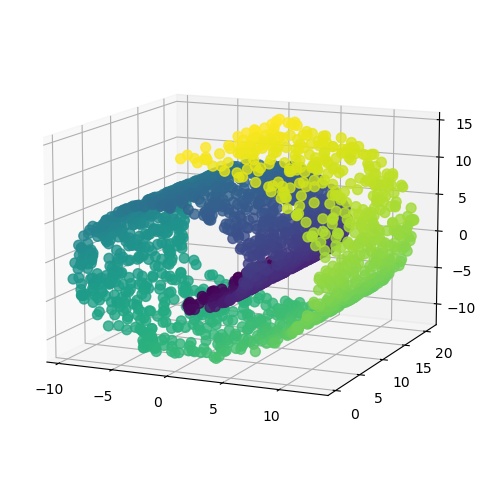

In [64]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")


ax.scatter(data[0][:,0], data[0][:,1], data[0][:,2],c=data_1_scaled, s=50, alpha=0.8)
ax.view_init(azim=-66, elev=12)
plt.show()

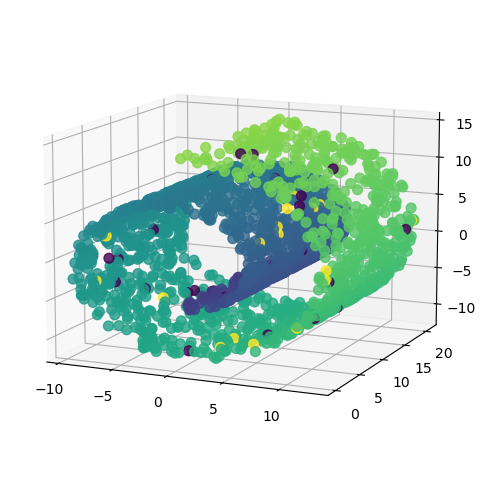

In [65]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")


ax.scatter(data[0][:,0], data[0][:,1], data[0][:,2],c=new_data_1, s=50, alpha=0.8)
ax.view_init(azim=-66, elev=12)
plt.show()

In [66]:
from sklearn.neighbors import kneighbors_graph

knn=kneighbors_graph(data[0], n_neighbors=62, mode='connectivity')
knn.toarray()[:10,:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

<p> First of all i've sed knn method to create a similarity graph from the swiss roll coordinat matrix (62 neighbors used as parameter of KNN). Then i''ve computed the normalized laplacian matrix. <br>
For the calculation of eigenvalue and eigenvector i've used the function built in in numpy, for more fancy matrix we could use other method (krylov space for spare matrix for example)
</p>

In [67]:
gr=nx.Graph(knn.toarray())
L=nx.normalized_laplacian_matrix(gr).toarray()

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [68]:
eigenValues, eigenVectors = np.linalg.eig(L)

idx = eigenValues.argsort() 
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

<p>
Since eigenvector of laplacian matrix could be seen as foureir basis, related eigenvalues could be seen as frequencies. The larger the eigenvalue the higher the frequency of corresponding eigenvector and viceversa. <br>
Using the Laplacian eigenvector matrix it's possible to apply a graph foureir transform to a signal and obtain a fourier transform one. So we can use fourer transformed signal and apply a filter to denoise our graph. </p>

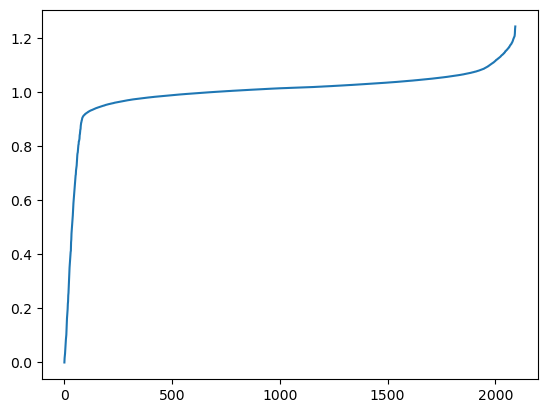

In [69]:
plt.plot(eigenValues)

<p>
Looking at the graph in which it has been plotted the graph fourer transformed signal of the original signal and the noised one, we can see that after 50 or 100 components the difference between the original signal (in red) and the noised one (blue), is quite relevant.
</p>

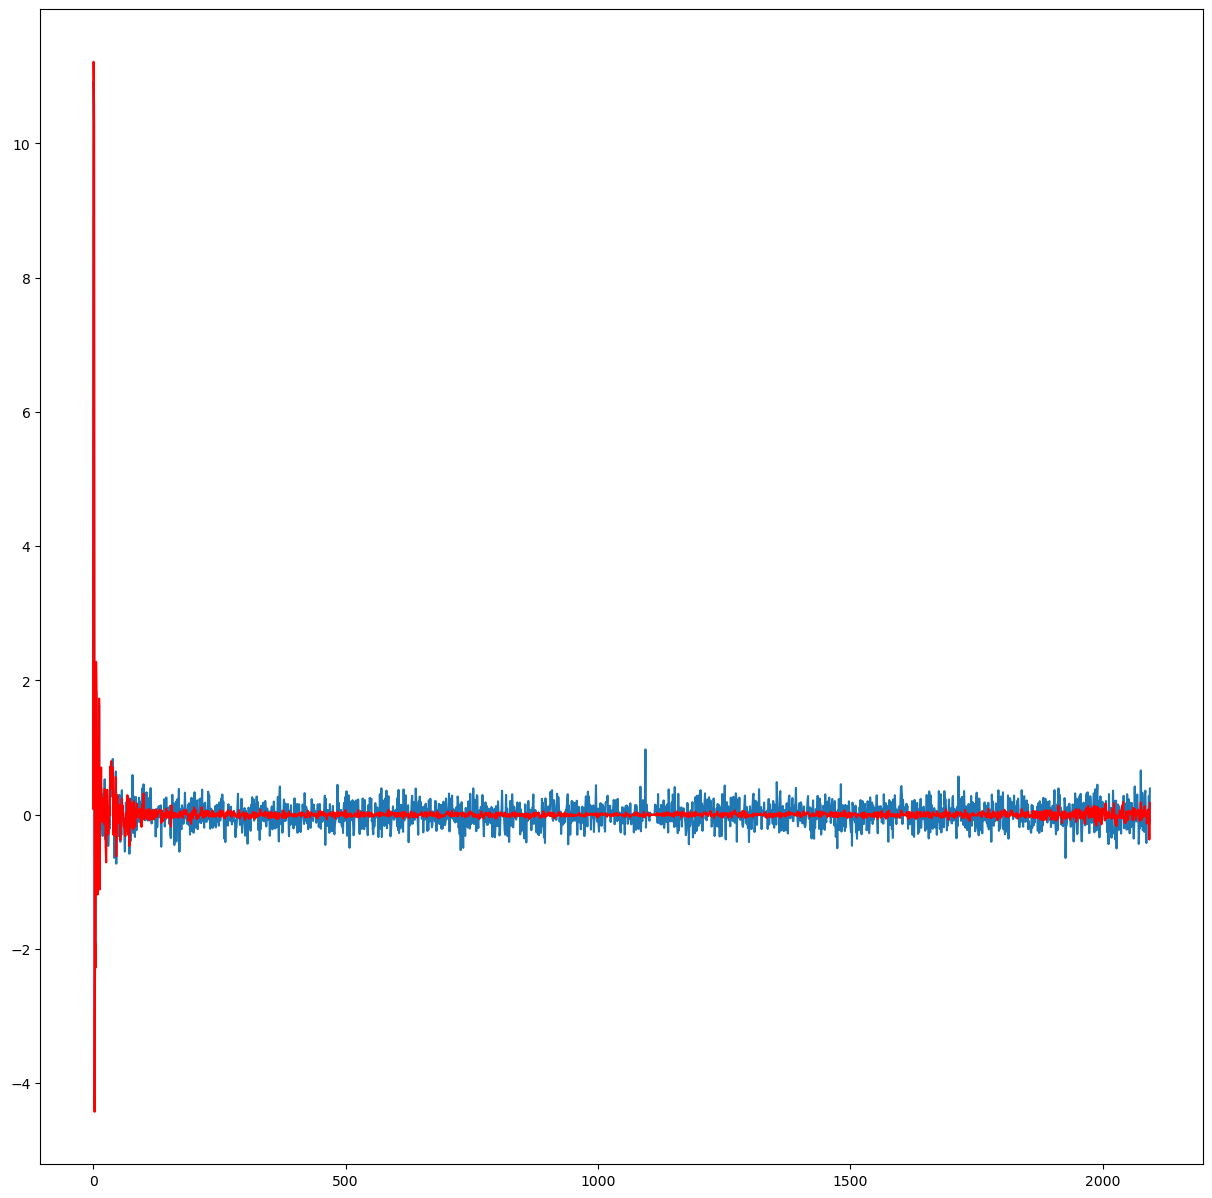

In [76]:
plt.figure(figsize=(15,15))

plt.plot(eigenVectors.T@new_data_1)
plt.plot(eigenVectors.T@data_1_scaled,c='red')
plt.show()

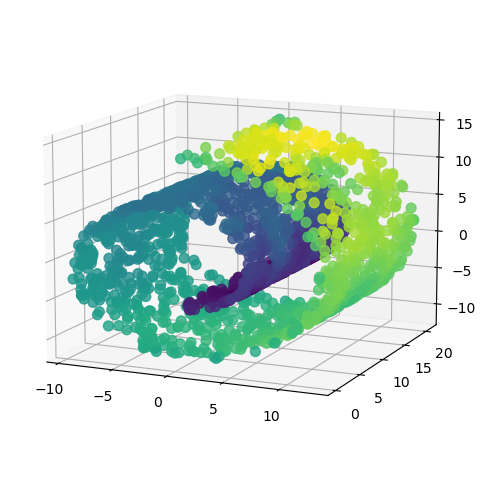

In [75]:
a=eigenVectors.T@new_data_1
x_denoised=np.concatenate((a[:50], np.repeat(0,len(a)-len(a[:50]))))

new_signal=eigenVectors@x_denoised

import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")


ax.scatter(data[0][:,0], data[0][:,1], data[0][:,2],c=new_signal, s=50, alpha=0.8)
ax.view_init(azim=-66, elev=12)
plt.show()

<p>
Let's apply a naive filter to our noised signal, in particular a low pass filter that cuts frequencies larger than 50.
Then let's apply the inverse graph fourier transform to obtain a denoised graph.
</p>